In [1]:
# Clustering methods
import json
import numpy as np
import pandas as pd
import os
from libraries.utils import get_paths, read_traces, read_json, mapint2var, is_consistent

In [2]:
# Configuration
CODE = 'theft_protection'               ### application (code) theft_protection, mamba2, lora_ducy
BEHAVIOUR_FAULTY = 'faulty_data'        ### normal, faulty_data
BEHAVIOUR_NORMAL = 'normal'             ### normal, faulty_data
THREAD = 'single'                       ### single, multi
VER = 3                                 ### format of data collection

base_dir = './trace_data'              ### can be replaced with 'csv', 'exe_plot', 'histogram'
normalbase_path = base_dir+f'/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_NORMAL}'
faultybase_path = base_dir+f'/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_FAULTY}'

print("Normal base path:", normalbase_path)
print("Faulty base path:", faultybase_path)

Normal base path: ./trace_data/theft_protection/single_thread/version_3/normal
Faulty base path: ./trace_data/theft_protection/single_thread/version_3/faulty_data


In [3]:
train_base_path = os.path.join(normalbase_path, 'train_data')
print("Train base path:", train_base_path)

train_data_path = [os.path.join(train_base_path, x) for x in os.listdir(train_base_path)]
train_varlist_path = [os.path.join(normalbase_path, x) for x in os.listdir(normalbase_path) if 'varlist' in x]

######### get paths #######################
paths_log, paths_traces, varlist_path, paths_label = get_paths(faultybase_path)

train_data_path = [x for x in train_data_path if '.DS_Store' not in x]
train_varlist_path = [x for x in train_varlist_path if '.DS_Store' not in x]
paths_log = [x for x in paths_log if '.DS_Store' not in x]
paths_traces = [x for x in paths_traces if '.DS_Store' not in x]
varlist_path = [x for x in varlist_path if '.DS_Store' not in x]
paths_label = [x for x in paths_label if '.DS_Store' not in x]

paths_log.sort()
paths_traces.sort()
varlist_path.sort()
paths_label.sort()

test_data_path = paths_traces
test_label_path = paths_label

Train base path: ./trace_data/theft_protection/single_thread/version_3/normal\train_data


In [4]:
# Function to read the data and transform into separate files with 50 as sequence length and window size of 1
import os
def read_process_train_data(file_path, sequence_length, window_size):
    count = 0
    output_directory = './train_data_processed/'
    filename_dictionary = {}
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for filename in file_path:
        result = []
        print("Reading file:", filename)
        count = count + 1
        with open(filename, 'r') as f:
            data = json.load(f)
        
        event_ids = [item[0] for item in data]
        timestamps = [item[1] for item in data]
        timestamp_difference = np.diff(timestamps).tolist()
        trimmed_event_ids = event_ids[1:]

        filename = f'trace_trial{count}' 

        for i in range(0, len(trimmed_event_ids) - sequence_length + 1, window_size):
            event_id_seq_len = trimmed_event_ids[i:i+sequence_length]
            timestamp_diff_seq_len = timestamp_difference[i:i+sequence_length]
            result = [event_id_seq_len, timestamp_diff_seq_len]

            index_start = i
            index_end = i + sequence_length
            new_filename = f'{filename}_{index_start}-{index_end}.json'
            output_path = os.path.join(output_directory, new_filename)

            #Saving the file
            with open(output_path, 'w') as out_file:
                json.dump(result, out_file)
            
            #Saving to dictionary for easy backtracking
            filename_dictionary[new_filename] = {
                "source_file": filename,
                "data_start_index": index_start,
                "data_end_index": index_end,
                "sequence_length": sequence_length,
                "window_size": window_size
            }
    
    dictionary_path = f'{output_directory}/file_dict/'
    if not os.path.exists(dictionary_path):
        os.makedirs(dictionary_path)
    
    dict_path = os.path.join(dictionary_path,'filename_dict.json')

    with open(dict_path, 'w') as track_dict:
        json.dump(filename_dictionary, track_dict, indent=2)
    
    print("Filename Dictionary saved to :", dict_path)

In [5]:
train_data_path

['./trace_data/theft_protection/single_thread/version_3/normal\\train_data\\interval_0_110.json',
 './trace_data/theft_protection/single_thread/version_3/normal\\train_data\\interval_1250_2000.json',
 './trace_data/theft_protection/single_thread/version_3/normal\\train_data\\interval_150_900.json',
 './trace_data/theft_protection/single_thread/version_3/normal\\train_data\\interval_2050_2300.json']

In [6]:
# processing the data
sequence_length = 50
window_size = 1
train_data_processed = read_process_train_data(train_data_path,sequence_length,window_size)

Reading file: ./trace_data/theft_protection/single_thread/version_3/normal\train_data\interval_0_110.json
Reading file: ./trace_data/theft_protection/single_thread/version_3/normal\train_data\interval_1250_2000.json
Reading file: ./trace_data/theft_protection/single_thread/version_3/normal\train_data\interval_150_900.json
Reading file: ./trace_data/theft_protection/single_thread/version_3/normal\train_data\interval_2050_2300.json
Filename Dictionary saved to : ./train_data_processed//file_dict/filename_dict.json


In [7]:
import os
import json
def load_train_data(file_path):
    traces = []
    filenames = []
    for file in os.listdir(file_path):
        if file.endswith('.json') and not file.startswith('filename_dict'):
            with open(os.path.join(file_path, file), 'r') as f:
                data = json.load(f)
                traces.append(data)
                filenames.append(file)
    return traces, filenames


In [8]:
# Feature extraction using Seglearn
from seglearn.feature_functions import all_features
from seglearn.transform import FeatureRep

def extract_features_seglearn(traces):
    feature_vectors = []
    funcs = all_features()
    if 'hist4' in funcs:
        del funcs['hist4']
    feature_names = list(funcs.keys())


    for i,trace in enumerate(traces):
        event_ids = np.array(trace[0]).reshape(1,-1,1)
        timestamp_diffs = np.array(trace[1]).reshape(1,-1,1)

        feat_all = []
        for name in feature_names:
            func = funcs[name]
            feat_event = func(event_ids)
            feat_time = func(timestamp_diffs)
            feat_all.extend(np.array(feat_event).reshape(-1,))
            feat_all.extend(np.array(feat_time).reshape(-1,))

        
        feature_vectors.append(feat_all)

    final_feature_names = []
    for name in feature_names:
        final_feature_names.append(f"{name}_event")
        final_feature_names.append(f"{name}_time")
    print("final_feature_names",len(final_feature_names))

    return pd.DataFrame(feature_vectors, columns=final_feature_names)
    

In [9]:
processed_train_data_path = './train_data_processed/'
traces, files = load_train_data(processed_train_data_path)

In [10]:
features_df = extract_features_seglearn(traces)

final_feature_names 54


In [11]:
from sklearn.cluster import KMeans

def cluster_features(df, n_clusters):
    kmeans = KMeans(n_clusters,init="k-means++", max_iter=300, n_init=30, random_state=42)
    kmeans.fit(df)
    labels = kmeans.labels_
    print("kmeans:", labels)
    return kmeans

In [12]:
from sklearn.metrics import silhouette_score

# Finding the best value for n clusters
def find_n_clusters_value(data, min_k, max_k):
    best_k = min_k
    best_score = -1

    for k in range(min_k, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        print(f"Silhouette score for k={k}: {score:.4f}")
        if score > best_score:
            best_score = score
            best_k = k
    
    return best_k

In [13]:
# Clustering
from sklearn.preprocessing import StandardScaler
import joblib

X_scaled = StandardScaler().fit_transform(features_df)

N_Clusters = find_n_clusters_value(X_scaled, min_k=2, max_k=10)
print("\n optimal number of clusters: ", N_Clusters)

kmeans_model = cluster_features(pd.DataFrame(X_scaled), N_Clusters)
features_df['cluster'] = kmeans_model.labels_
features_df['file'] = files

model_save_path = './trained_model/'
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

joblib.dump(kmeans_model, f'{model_save_path}kmeans_model.pkl')



print("\n Cluster assignments")
print(features_df[['file', 'cluster']])

features_df.to_csv("clustered_features_seglearn.csv", index=False)
print("\n file saved")

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
 

Silhouette score for k=2: 0.4721
Silhouette score for k=3: 0.4674
Silhouette score for k=4: 0.4560
Silhouette score for k=5: 0.4469
Silhouette score for k=6: 0.4039
Silhouette score for k=7: 0.4051
Silhouette score for k=8: 0.3846
Silhouette score for k=9: 0.3998
Silhouette score for k=10: 0.4113

 optimal number of clusters:  2
kmeans: [0 0 0 ... 1 1 0]

 Cluster assignments
                          file  cluster
0       trace_trial1_0-50.json        0
1       trace_trial1_1-51.json        0
2      trace_trial1_10-60.json        0
3      trace_trial1_11-61.json        0
4      trace_trial1_12-62.json        1
...                        ...      ...
1655  trace_trial4_95-145.json        1
1656  trace_trial4_96-146.json        1
1657  trace_trial4_97-147.json        1
1658  trace_trial4_98-148.json        1
1659  trace_trial4_99-149.json        0

[1660 rows x 2 columns]

 file saved


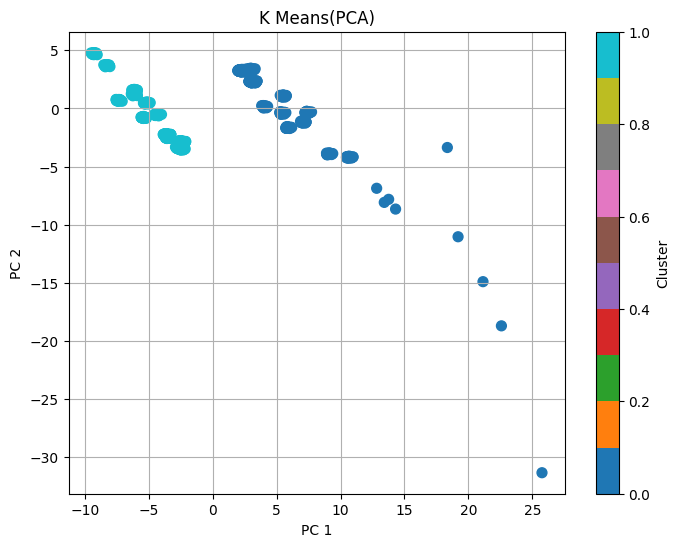

In [14]:
# Plotting the clusters
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=features_df['cluster'], cmap='tab10', s=50)
plt.title("K Means(PCA)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()


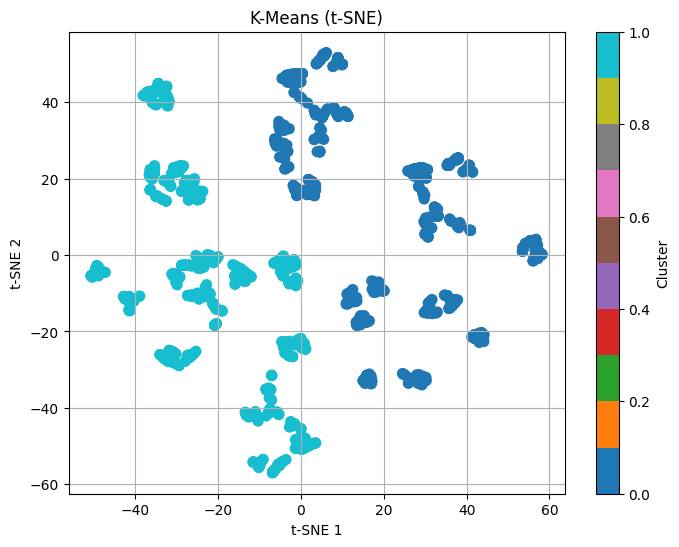

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=features_df['cluster'], cmap='tab10', s=50)
plt.title("K-Means (t-SNE)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()

In [16]:
# Testing phase with faulty data

test_data_path

['./trace_data/theft_protection/single_thread/version_3/faulty_data\\trace_trial1.json',
 './trace_data/theft_protection/single_thread/version_3/faulty_data\\trace_trial2.json',
 './trace_data/theft_protection/single_thread/version_3/faulty_data\\trace_trial3.json']

In [17]:
import os
def read_process_test_data(file_path, sequence_length):
    count = 0
    output_directory = './test_data_processed/'
    filename_dictionary = {}
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for filename in file_path:
        result = []
        print("Reading file:", filename)
        count = count + 1
        with open(filename, 'r') as f:
            data = json.load(f)
        
        event_ids = [item[0] for item in data]
        timestamps = [item[1] for item in data]
        timestamp_difference = np.diff(timestamps).tolist()
        trimmed_event_ids = event_ids[1:]

        filename = f'trace_trial{count}' 

        for i in range(0, len(trimmed_event_ids) - sequence_length + 1, sequence_length):
            event_id_seq_len = trimmed_event_ids[i:i+sequence_length]
            timestamp_diff_seq_len = timestamp_difference[i:i+sequence_length]
            result = [event_id_seq_len, timestamp_diff_seq_len]

            index_start = i
            index_end = i + sequence_length
            new_filename = f'{filename}_{index_start}-{index_end}.json'
            output_path = os.path.join(output_directory, new_filename)

            #Saving the file
            with open(output_path, 'w') as out_file:
                json.dump(result, out_file)
            
            #Saving to dictionary for easy backtracking
            filename_dictionary[new_filename] = {
                "source_file": filename,
                "data_start_index": index_start,
                "data_end_index": index_end,
                "sequence_length": sequence_length,
                "window_size": window_size
            }
    
    dictionary_path = f'{output_directory}/file_dict/'
    if not os.path.exists(dictionary_path):
        os.makedirs(dictionary_path)
    
    dict_path = os.path.join(dictionary_path,'filename_dict.json')

    with open(dict_path, 'w') as track_dict:
        json.dump(filename_dictionary, track_dict, indent=2)
    
    print("Filename Dictionary saved to :", dict_path)

In [18]:
# processing the data
sequence_length = 50
train_data_processed = read_process_test_data(train_data_path,sequence_length)

Reading file: ./trace_data/theft_protection/single_thread/version_3/normal\train_data\interval_0_110.json
Reading file: ./trace_data/theft_protection/single_thread/version_3/normal\train_data\interval_1250_2000.json
Reading file: ./trace_data/theft_protection/single_thread/version_3/normal\train_data\interval_150_900.json
Reading file: ./trace_data/theft_protection/single_thread/version_3/normal\train_data\interval_2050_2300.json
Filename Dictionary saved to : ./test_data_processed//file_dict/filename_dict.json
